___
<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Principal Components Analysis 


---

In this lab, let's try PCA on a dataset derived from the USDA National Nutrient Database.

**Import libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline

**Import the data**

In [2]:
df = pd.read_csv('../../assets/data/nutrition_usda.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8618 entries, 0 to 8617
Data columns (total 45 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                8618 non-null   int64  
 1   FoodGroup         8618 non-null   object 
 2   ShortDescrip      8618 non-null   object 
 3   Descrip           8618 non-null   object 
 4   CommonName        1063 non-null   object 
 5   MfgName           1560 non-null   object 
 6   ScientificName    732 non-null    object 
 7   Energy_kcal       8618 non-null   float64
 8   Protein_g         8618 non-null   float64
 9   Fat_g             8618 non-null   float64
 10  Carb_g            8618 non-null   float64
 11  Sugar_g           8618 non-null   float64
 12  Fiber_g           8618 non-null   float64
 13  VitA_mcg          8618 non-null   float64
 14  VitB6_mg          8618 non-null   float64
 15  VitB12_mcg        8618 non-null   float64
 16  VitC_mg           8618 non-null   float64


#### Let's check for highly correlated features in our dataset.

In [4]:
used = []
corrs = []
for i, j in enumerate(df.corr().columns):
    for k in range(len(df.corr())):
        if ((df.corr().iloc[k, i] > 0.9) & 
            (j not in used) &
            (j != df.corr().index[k])):
            
            used.append(j)
            corrs.append((j, df.corr().index[k], 
                          np.round(df.corr().iloc[k, i], 2)))

            
corrsdf = pd.DataFrame([[i[0] for i in corrs],
                        [i[1] for i in corrs],
                        [i[2] for i in corrs]])

corrsdf = corrsdf.T.rename(columns = {0:'column',1:'row',2:'corr'})
corrsdf[:15]

,column,row,corr
0,VitA_mcg,VitA_USRDA,1.0
1,VitB6_mg,VitB6_USRDA,1.0
2,VitB12_mcg,VitB12_USRDA,1.0
3,VitC_mg,VitC_USRDA,1.0
4,VitE_mg,VitE_USRDA,1.0
5,Folate_mcg,Folate_USRDA,1.0
6,Niacin_mg,Niacin_USRDA,1.0
7,Riboflavin_mg,Riboflavin_USRDA,1.0
8,Thiamin_mg,Thiamin_USRDA,1.0
9,Calcium_mg,Calcium_USRDA,1.0


**Remove redundant features**

We can see that the "_USRDA" features are redundant. They should be removed

In [5]:
df.drop(df.columns[df.columns.str.contains('_USRDA')].values, 
        inplace=True, axis=1)

#### Next, separate the non-numeric features

In [6]:
df.set_index('ID', inplace=True)
df_desc = df.iloc[:, :6]
df.drop(df.columns[:6].values, axis=1, inplace=True)

**Now, look at the data distribution**

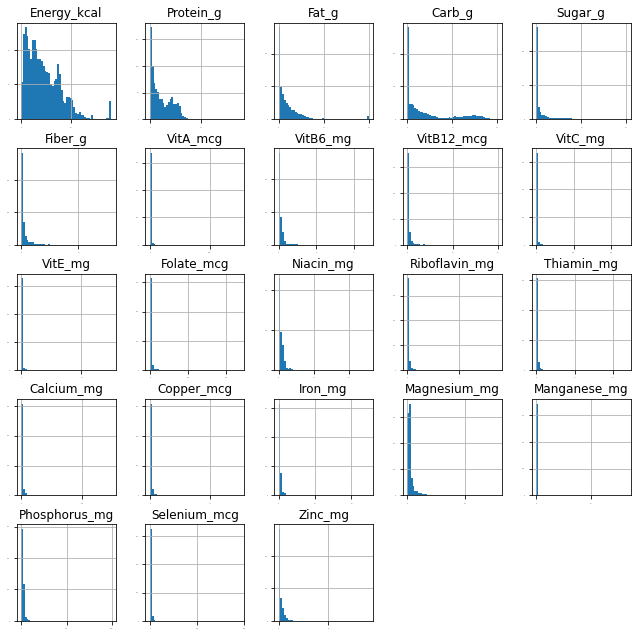

In [7]:
ax = df.hist(bins=50, xlabelsize=-1, ylabelsize=-1, figsize=(11,11))

Most of the variables are "zero" inflated and skewed right. We may want to consider transformation so "improve" the distributions and hopefully produce better correlations for our PCA. 

Note: this is an optional step that may not always improve results.

In [8]:
from scipy.stats import boxcox
# add 1 because data must be positive (we have many zeros)
df = df + 1
df_TF = pd.DataFrame(index=df.index)
for i in df.columns.values:
    df_TF["%s_TF" % i] = boxcox(df.loc[:, i])[0]

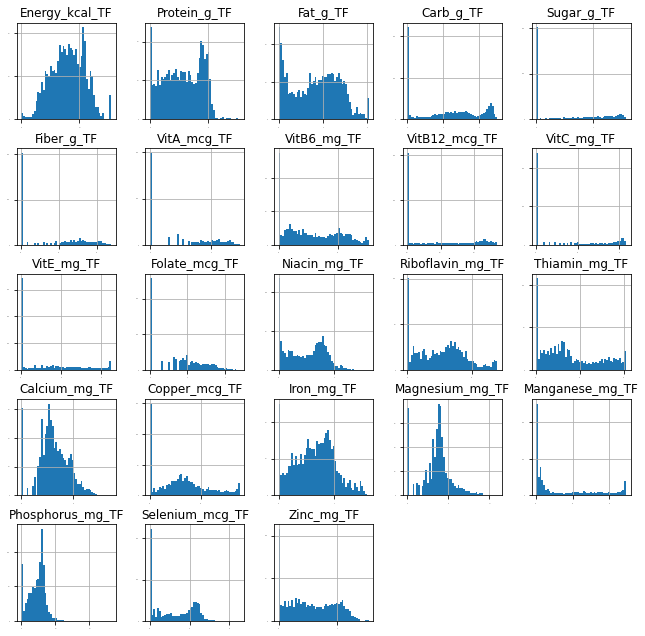

In [9]:
ax = df_TF.hist(bins=50, xlabelsize=-1, ylabelsize=-1, figsize=(11,11))

This should help our PCA.

To account for different scales of measurement, we'll standardize to mean=0, variance=1.

In [10]:
# from sklearn.preprocessing import StandardScaler
df_TF = StandardScaler().fit_transform(df_TF)

print("mean: ", np.round(df_TF.mean(), 2))
print("standard dev: ", np.round(df_TF.std(), 2))

mean:  0.0
standard dev:  1.0


**Implement PCA**

In [11]:
# from sklearn.decomposition import PCA
fit = PCA()
pca = fit.fit_transform(df_TF)


#### check the eigenvalues to find most important components


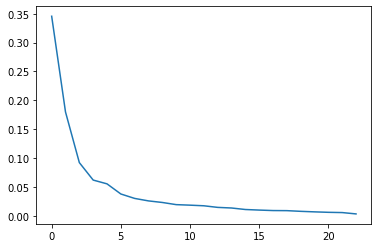

In [12]:
plt.plot(fit.explained_variance_ratio_)

In [13]:
print(fit.explained_variance_ratio_)

print(fit.explained_variance_ratio_[:5].sum())

[0.34554936 0.17971019 0.09201387 0.06176452 0.05520037 0.03764111
 0.02996247 0.02566808 0.02294417 0.0192006  0.01828886 0.01721459
 0.01443828 0.01337614 0.0107629  0.00977106 0.00894584 0.00878398
 0.00760274 0.00668982 0.00589323 0.00545379 0.00312402]
0.7342383069149604


#### the first 5 eigenvectors account for 73% of the variance and will be kept

In [14]:
pca = pd.DataFrame(pca[:, :5], index=df.index)
pca = pca.join(df_desc)
pca.drop(['CommonName','MfgName','ScientificName'], axis=1, inplace=True)
pca.rename(columns={0:'c1',1:'c2',2:'c3',3:'c4',4:'c5'}, inplace=True)

In [15]:
# we see that the five vectors are orthogonal
np.round(pca.corr(), 5)

,c1,c2,c3,c4,c5
c1,1.0,-0.0,-0.0,-0.0,-0.0
c2,-0.0,1.0,-0.0,0.0,0.0
c3,-0.0,-0.0,1.0,0.0,-0.0
c4,-0.0,0.0,0.0,1.0,-0.0
c5,-0.0,0.0,-0.0,-0.0,1.0


**Try to interpret the components**

(this is where deep subject matter expertise, in this case nutrition, comes in handy)

**Component one** 

foods that are high in: zinc, and other vitamins and minerals

low in: sugar, vitamin C, Carbs, and fiber

In [16]:
vects = fit.components_[:5]

one = pd.Series(vects[0], index=df.columns)
one.sort_values(ascending=False)

Zinc_mg          0.308506
Phosphorus_mg    0.305000
Niacin_mg        0.294094
Protein_g        0.286086
Riboflavin_mg    0.282687
VitB6_mg         0.270646
Selenium_mcg     0.264114
Iron_mg          0.262314
Magnesium_mg     0.260245
Thiamin_mg       0.235440
VitB12_mcg       0.221322
Copper_mcg       0.220232
Folate_mcg       0.167856
Energy_kcal      0.165126
Fat_g            0.161488
Calcium_mg       0.135512
VitE_mg          0.090808
Manganese_mg     0.088762
VitA_mcg         0.056996
Fiber_g         -0.004663
Carb_g          -0.033767
VitC_mg         -0.069830
Sugar_g         -0.076132
dtype: float64

**Component two**

High: Carbs, Fiber, Mang, Sugar, Vitamin C...

Low: Vitamine B12, protein, selenium, Fat...

In [17]:
two = pd.Series(vects[1], index=df.columns)
two.sort_values(ascending=False)

Carb_g           0.414542
Fiber_g          0.397832
Manganese_mg     0.343603
Sugar_g          0.295640
VitC_mg          0.242314
Folate_mcg       0.238391
Calcium_mg       0.231052
Magnesium_mg     0.199838
Copper_mcg       0.181631
Thiamin_mg       0.159641
Iron_mg          0.118917
VitE_mg          0.104310
VitA_mcg         0.095701
Energy_kcal      0.041850
Riboflavin_mg    0.024240
Phosphorus_mg   -0.001517
VitB6_mg        -0.052166
Niacin_mg       -0.064197
Zinc_mg         -0.100529
Fat_g           -0.123575
Selenium_mcg    -0.138883
Protein_g       -0.196127
VitB12_mcg      -0.265671
dtype: float64

**Component three**

High: calories, fat, carbs, sugar...

Low: vitamin A, vitamin C, folate, copper...

In [18]:
three = pd.Series(vects[2], index=df.columns)
three.sort_values(ascending=False)

Energy_kcal      0.508062
Fat_g            0.409505
Carb_g           0.250952
Sugar_g          0.208651
Thiamin_mg       0.191124
Fiber_g          0.153640
Iron_mg          0.115065
Riboflavin_mg    0.062074
Niacin_mg        0.055991
Protein_g        0.026828
Phosphorus_mg   -0.010948
VitE_mg         -0.012473
Zinc_mg         -0.051002
Magnesium_mg    -0.100792
VitB12_mcg      -0.107476
Manganese_mg    -0.108755
VitB6_mg        -0.121850
Calcium_mg      -0.125621
Selenium_mcg    -0.131798
Copper_mcg      -0.177702
Folate_mcg      -0.264298
VitA_mcg        -0.298089
VitC_mg         -0.334490
dtype: float64

**Component four**

High: vitamin A, vitamin E, fat, sugar, calcium, vitamin B12, calories...

Low: manganese, copper, iron, magnesium, fiber

In [19]:
four = pd.Series(vects[3], index=df.columns)
four.sort_values(ascending=False)

VitA_mcg         0.539792
VitE_mg          0.537710
Fat_g            0.282774
Sugar_g          0.279657
Calcium_mg       0.188343
VitB12_mcg       0.167068
Energy_kcal      0.158787
VitC_mg          0.129288
Selenium_mcg     0.063452
Riboflavin_mg    0.061855
Folate_mcg       0.011655
VitB6_mg        -0.011382
Phosphorus_mg   -0.022623
Carb_g          -0.025185
Zinc_mg         -0.055472
Niacin_mg       -0.065223
Thiamin_mg      -0.086530
Protein_g       -0.090944
Fiber_g         -0.119122
Magnesium_mg    -0.131683
Iron_mg         -0.149698
Copper_mcg      -0.167872
Manganese_mg    -0.203804
dtype: float64

**Component five**

High: riboflavin, thiamin, niacin, sugar, vitB6, vitC, vitB12...

Low: manganese, copper, fat, vitE, calories, magnesium

In [20]:
five = pd.Series(vects[4], index=df.columns)
five.sort_values(ascending=False)

Riboflavin_mg    0.322545
Thiamin_mg       0.281944
Niacin_mg        0.264423
Sugar_g          0.264262
VitB6_mg         0.254663
VitC_mg          0.249634
VitB12_mcg       0.195637
Iron_mg          0.158585
Carb_g           0.101396
Fiber_g          0.075900
VitA_mcg         0.057928
Zinc_mg         -0.029074
Calcium_mg      -0.035398
Protein_g       -0.046148
Phosphorus_mg   -0.084178
Folate_mcg      -0.105000
Magnesium_mg    -0.143789
Selenium_mcg    -0.163561
Energy_kcal     -0.204336
VitE_mg         -0.250605
Fat_g           -0.266740
Copper_mcg      -0.316998
Manganese_mg    -0.347515
dtype: float64

**Now let's look at which food groups are most common in each component**

#### Component 1 

In [21]:
pca.sort_values(by='c1')['FoodGroup'][:500].value_counts()

Soups, Sauces, and Gravies             190
Beverages                              167
Sweets                                  45
Vegetables and Vegetable Products       20
Legumes and Legume Products             16
Fruits and Fruit Juices                 16
Baby Foods                              10
Meals, Entrees, and Side Dishes          9
Fats and Oils                            7
Spices and Herbs                         7
American Indian/Alaska Native Foods      5
Snacks                                   3
Fast Foods                               2
Baked Products                           2
Sausages and Luncheon Meats              1
Name: FoodGroup, dtype: int64

#### Component 2

In [22]:
pca.sort_values(by='c2')['FoodGroup'][:500].value_counts()

Beef Products                          353
Lamb, Veal, and Game Products           71
Poultry Products                        21
Fats and Oils                           13
American Indian/Alaska Native Foods     13
Pork Products                            9
Finfish and Shellfish Products           8
Sausages and Luncheon Meats              4
Fast Foods                               3
Restaurant Foods                         3
Beverages                                2
Name: FoodGroup, dtype: int64

#### Component 3

In [23]:
pca.sort_values(by='c3')['FoodGroup'][:500].value_counts()

Vegetables and Vegetable Products      344
Finfish and Shellfish Products          68
Poultry Products                        19
Beverages                               10
Soups, Sauces, and Gravies              10
Lamb, Veal, and Game Products            9
Fruits and Fruit Juices                  9
Baby Foods                               7
Spices and Herbs                         6
Fast Foods                               5
Pork Products                            4
Beef Products                            4
American Indian/Alaska Native Foods      2
Nut and Seed Products                    2
Dairy and Egg Products                   1
Name: FoodGroup, dtype: int64

#### Component 4

In [24]:
pca.sort_values(by='c4')['FoodGroup'][:500].value_counts()

Legumes and Legume Products            124
Cereal Grains and Pasta                 98
Vegetables and Vegetable Products       89
Baked Products                          39
Nut and Seed Products                   34
Breakfast Cereals                       23
Snacks                                  19
American Indian/Alaska Native Foods     18
Beverages                               16
Sweets                                  15
Sausages and Luncheon Meats              6
Lamb, Veal, and Game Products            6
Spices and Herbs                         5
Soups, Sauces, and Gravies               2
Finfish and Shellfish Products           2
Fruits and Fruit Juices                  2
Poultry Products                         1
Baby Foods                               1
Name: FoodGroup, dtype: int64

#### Component 5

In [25]:
pca.sort_values(by='c5')['FoodGroup'][:500].value_counts()

Fats and Oils                          145
Nut and Seed Products                   81
Sweets                                  51
Legumes and Legume Products             50
Snacks                                  41
Baked Products                          24
Sausages and Luncheon Meats             17
American Indian/Alaska Native Foods     16
Dairy and Egg Products                  13
Cereal Grains and Pasta                 12
Finfish and Shellfish Products          12
Breakfast Cereals                        8
Fast Foods                               5
Spices and Herbs                         4
Restaurant Foods                         4
Beef Products                            3
Beverages                                3
Poultry Products                         3
Lamb, Veal, and Game Products            2
Pork Products                            2
Soups, Sauces, and Gravies               1
Vegetables and Vegetable Products        1
Baby Foods                               1
Fruits and 